# CSCA 5632: Unsupervised Algorithms in Machine Learning – Final Project  
## ⚽ Player Style Classification in Soccer  

**Name:** Olaniyi Nafiu  

---

## 📌 Project Description  
This project focuses on performing **Exploratory Data Analysis (EDA)** and building **unsupervised machine learning models**. The goal is to identify **players with similar playing styles** using player performance data.  

In modern football, managers aim to recruit players that align with their system or philosophy. Having a database that classifies players by playing style helps clubs:
- Easily find players who fit specific roles.
- Rank transfer targets based on their similarity to desired profiles.

---

## 📊 Dataset  
The project uses the **European Soccer Database** by Hugo Mathien, available on Kaggle. This comprehensive dataset includes:
- 25,000+ matches  
- 10,000+ players  
- 11 European countries  
- Detailed match statistics, player attributes, and team data  

**Source:** [European Soccer Database – Kaggle](https://www.kaggle.com/datasets/hugomathien/soccer)

> **Citation (APA):**  
> Mathien, H. (n.d.). *European Soccer Database*. Kaggle.

---

## 🔍 Data Description  
The SQLite database includes several tables. This project focuses primarily on the `Player_Attributes` table:

| Table Name         | Rows    | Columns |
|--------------------|---------|---------|
| Country            | 11      | 2       |
| League             | 11      | 3       |
| Match              | 25,979  | 115     |
| Player             | 11,060  | 7       |
| **Player_Attributes** | **183,978** | **42**      |
| Team               | 299     | 5       |
| Team_Attributes    | 1,458   | 25      |

The `Player_Attributes` table contains **~184K rows and 42 columns**. This data will be cleaned and filtered to extract the most relevant features for clustering player styles.

---


In [69]:
## Imports
import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


In [70]:
## Fetch Data
import sqlite3
import pandas as pd

conn = sqlite3.connect("database.sqlite")
df = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
players = pd.read_sql_query("SELECT * FROM Player", conn)
print(df.shape)
df.head()

(183978, 42)


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [71]:
## Exploratory Data Analysis: Data Cleaning

### Missing Data
missing_data = df.isnull().sum()
print(f"Missing Data:\n{missing_data}\n")

num_rows_with_missing_data = df.isnull().any(axis=1).sum()
print(f"Cumulative Missing Data Rows: {num_rows_with_missing_data} rows\n")

missing_percentage = (num_rows_with_missing_data / df.shape[0]) * 100
print(f"Percentage of rows with missing data: {missing_percentage:.2f}%\n")

print("Since there are only 3,624 rows with missing data out of 183,978 (1.97%), those rows will be removed.")
df_cleaned = df.dropna()

### Duplicate Rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}\n")
print("There are no duplicate rows.")

### Remove non feature columns
df_cleaned = df_cleaned.drop(columns=['id', 'player_api_id', 'date'])
df_cleaned.shape

Missing Data:
id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standi

(180354, 39)

In [72]:
## Exploratory Data Analysis: Review and Update Feature Data Types
summary_stats = df_cleaned.describe()
print(f"Summary Statistics:\n{summary_stats}\n")

# Map string data types to integers
df_cleaned['attacking_work_rate'] = df_cleaned['attacking_work_rate'].apply(
    lambda x: x if x in ['low', 'medium', 'high'] else 'medium'
)
df_cleaned['defensive_work_rate'] = df_cleaned['defensive_work_rate'].apply(
    lambda x: x if x in ['low', 'medium', 'high'] else 'medium'
)

# Map to integers
work_rate_map = {'low': 0, 'medium': 1, 'high': 2}
df_cleaned['attacking_work_rate'] = df_cleaned['attacking_work_rate'].map(work_rate_map)
df_cleaned['defensive_work_rate'] = df_cleaned['defensive_work_rate'].map(work_rate_map)
df_cleaned['preferred_foot'] = df_cleaned['preferred_foot'].map({'right': 1, 'left': 0})
df_cleaned.info()

Summary Statistics:
       player_fifa_api_id  overall_rating      potential       crossing  \
count       180354.000000   180354.000000  180354.000000  180354.000000   
mean        166822.125803       68.635317      73.479457      55.142071   
std          52821.443279        7.027950       6.581963      17.247231   
min              2.000000       33.000000      39.000000       1.000000   
25%         156616.000000       64.000000      69.000000      45.000000   
50%         183792.000000       69.000000      74.000000      59.000000   
75%         200138.000000       73.000000      78.000000      68.000000   
max         234141.000000       94.000000      97.000000      95.000000   

           finishing  heading_accuracy  short_passing        volleys  \
count  180354.000000     180354.000000  180354.000000  180354.000000   
mean       49.962136         57.263476      62.486726      49.488927   
std        19.041760         16.478716      14.172493      18.252319   
min         1.00

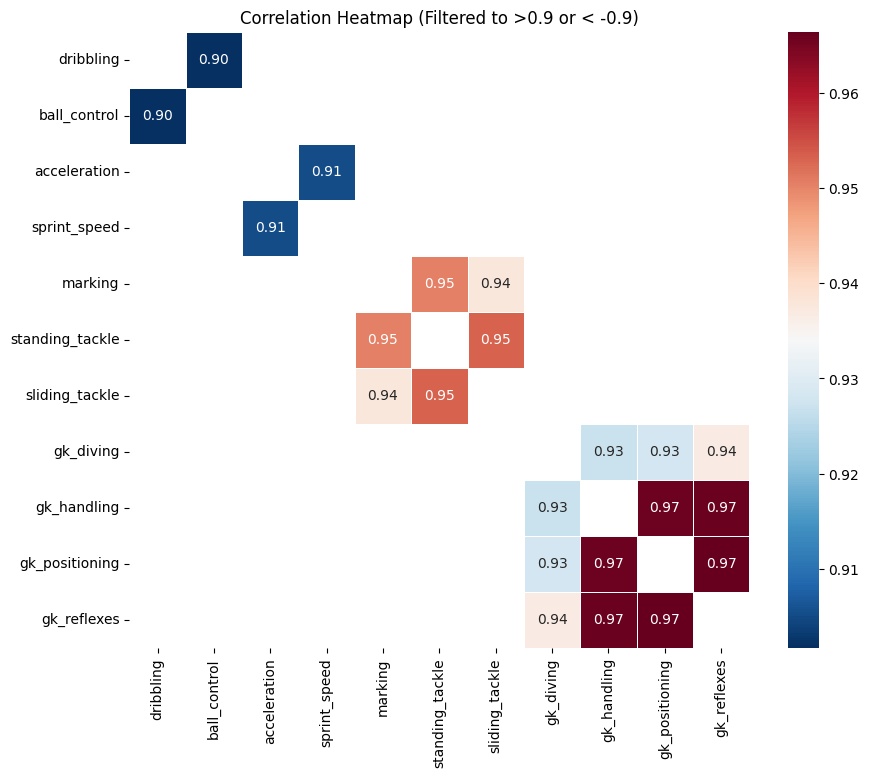

The following features are highly correlated and one will be dropped:
dribbling and ball_control, ball_control dropped
acceleration and sprint_speed, sprint_speed dropped
marking, standing_tackle, sliding_tackle, standing_tackle and sliding_tackle dropped
gk_diving, gk_handling, gk_positioning, gk_reflexes, gk_handling, gk_positioning and gk_reflexes dropped


(180354, 32)

In [73]:
## Exploratory Data Analysis: Correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

corr_matrix = df_cleaned.corr()

corr_matrix_filtered = corr_matrix.where((corr_matrix > 0.9) | (corr_matrix < -0.9))
np.fill_diagonal(corr_matrix_filtered.values, np.nan)
corr_matrix_filtered = corr_matrix_filtered.dropna(axis=0, how='all').dropna(axis=1, how='all')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_filtered, annot=True, cmap='RdBu_r', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap (Filtered to >0.9 or < -0.9)")
plt.show()

print("The following features are highly correlated and one will be dropped:\n"
      "dribbling and ball_control, ball_control dropped\n"
      "acceleration and sprint_speed, sprint_speed dropped\n"
      "marking, standing_tackle, sliding_tackle, standing_tackle and sliding_tackle dropped\n"
      "gk_diving, gk_handling, gk_positioning, gk_reflexes, gk_handling, gk_positioning and gk_reflexes dropped")

df_cleaned_2 = df_cleaned.drop(columns=['ball_control', 'sprint_speed', 'standing_tackle', 'sliding_tackle', 'gk_handling', 'gk_positioning', 'gk_reflexes'])
df_cleaned_2.shape


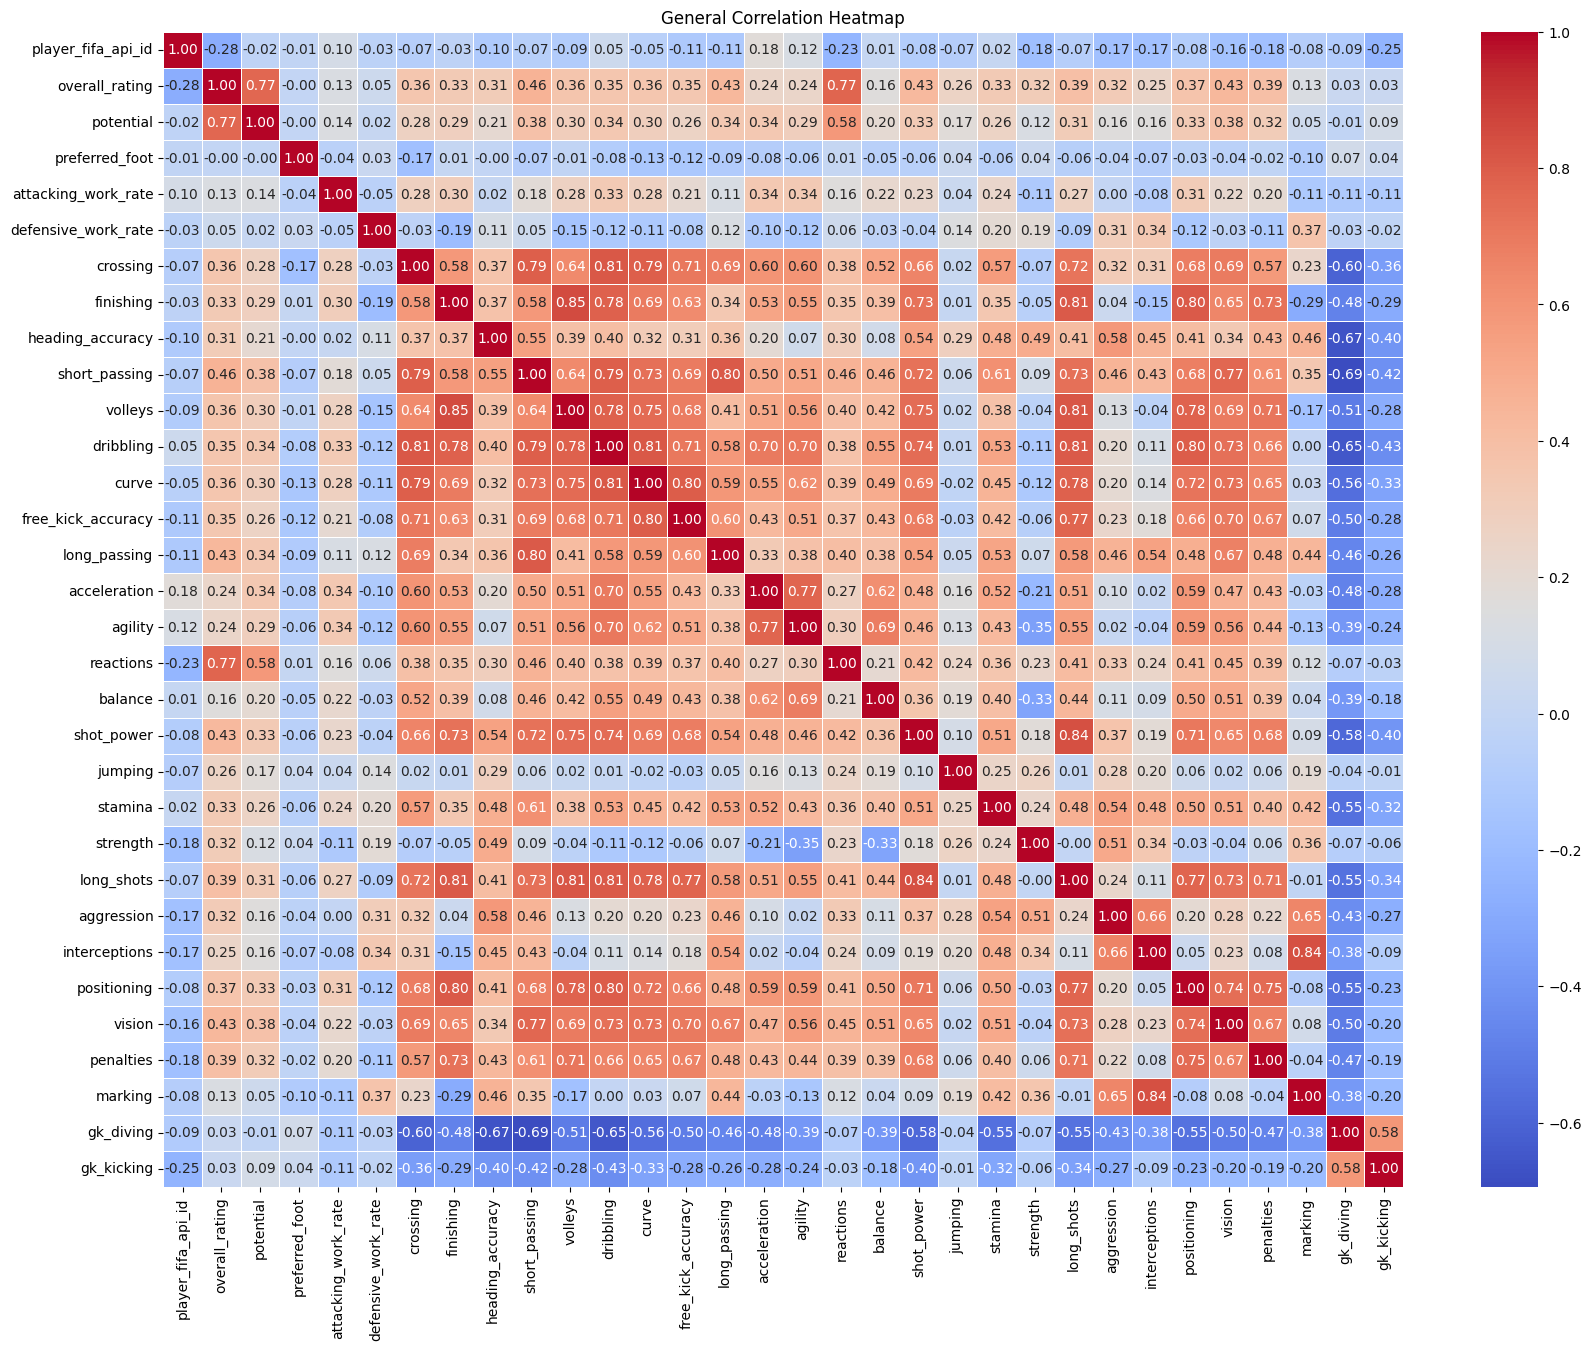

The are still some highly correlated features but will keep them because they are less than 80


In [74]:
## Exploratory Data Analysis: Correlation heatmap Cont'd

corr_matrix = df_cleaned_2.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("General Correlation Heatmap")
plt.show()

print("The are still some highly correlated features but will keep them because they are less than 80")

/var/folders/29/pcgxrbyn6nnbkh5g1dvhbb_m0000gn/T/ipykernel_2829/3473120668.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_cleaned_2, x='preferred_foot', palette='Set2')


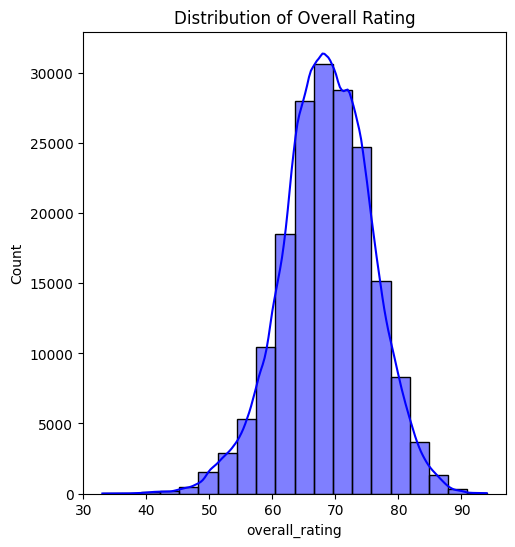

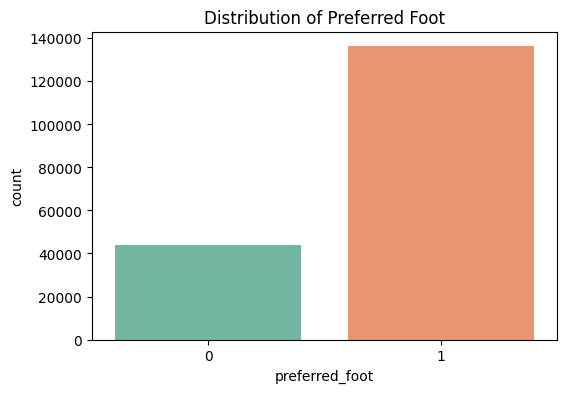

Text(0.5, 1.0, 'Distribution of Acceleration')

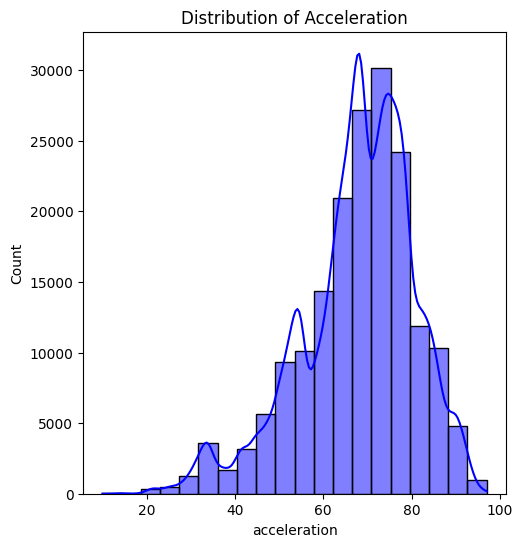

In [75]:
## Exploratory Data Analysis: Visualize some features' distribution

# Distribution of Overall Rating
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned_2['overall_rating'], bins=20, kde=True, color='blue')
plt.title("Distribution of Overall Rating")


# Distribution of Player Foot Preference
plt.figure(figsize=(6, 4))
sns.countplot(data=df_cleaned_2, x='preferred_foot', palette='Set2')
plt.title("Distribution of Preferred Foot")
plt.show()

# Distribution of Acceleration
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned_2['acceleration'], bins=20, kde=True, color='blue')
plt.title("Distribution of Acceleration")

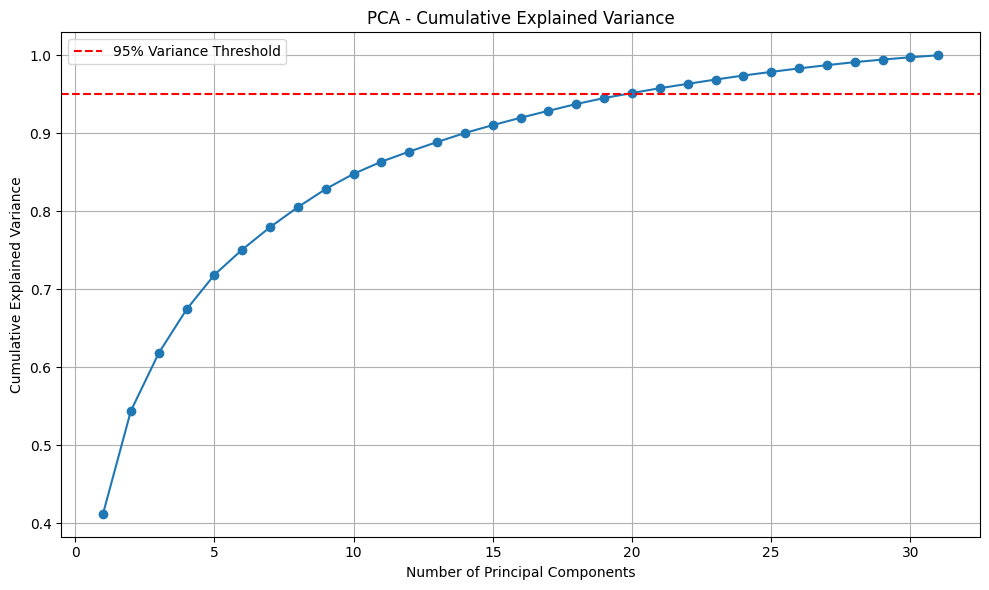

The number of components that meets the 95% threshold is 20
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.532858  1.583746 -1.635865  0.706930  0.376461 -0.590449 -0.268494   
1  1.532858  1.583746 -1.635865  0.706930  0.376461 -0.590449 -0.268494   
2  1.904674  0.694981 -2.198555  1.077640  0.091778 -0.590994 -0.177953   
3  2.149611  0.582999 -2.382007  1.088913 -0.010926 -0.585891 -0.165068   
4  2.149611  0.582999 -2.382007  1.088913 -0.010926 -0.585891 -0.165068   

        PC8       PC9      PC10  ...      PC12      PC13      PC14      PC15  \
0 -0.683758  0.491080  0.452564  ...  0.055362  0.859846 -0.711445 -0.671350   
1 -0.683758  0.491080  0.452564  ...  0.055362  0.859846 -0.711445 -0.671350   
2 -0.386647  0.316679  0.187160  ...  0.025216  0.962364 -0.282131 -0.560451   
3 -0.358691  0.305484  0.179652  ...  0.012111  0.990452 -0.251625 -0.558863   
4 -0.358691  0.305484  0.179652  ...  0.012111  0.990452 -0.251625 -0.558863   

       P

In [76]:
## EDA: Feature reduction to speed up training and reduce overfitting

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
features = df_cleaned_2.drop(columns=['player_fifa_api_id'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA()
pca.fit(scaled_features)

# Calculate the number of components needed to explain 95% of the variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components_95 = (cumulative_variance >= 0.95).argmax() + 1

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         cumulative_variance, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend()
plt.tight_layout()
plt.show()

print(f"The number of components that meets the 95% threshold is {n_components_95}")

# Apply PCA with the number of components that meet the 95% variance threshold
pca = PCA(n_components=n_components_95)
principal_components = pca.fit_transform(scaled_features)

columns = [f"PC{i+1}" for i in range(n_components_95)]
df_pca = pd.DataFrame(principal_components, columns=columns)

df_pca['player_fifa_api_id'] = df_cleaned_2['player_fifa_api_id'].values

print(df_pca.head())
print(df_pca.shape)

print("Given that 2/3 of the features are needed to explain 95% of the variance "
      "and the total number of features is relatively small, "
      "I won't use the PCA results for modeling. Instead, I'll use the raw data.")

Best Parameters from GridSearchCV:
{'init': 'random', 'n_clusters': 18}


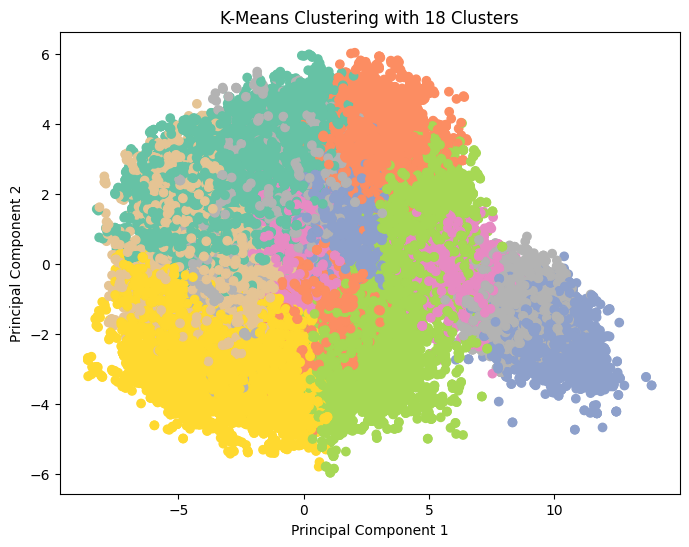

Hyperparametuning results in highest value of n_clusters, will use elbow method to select optimal value


In [77]:
## Model Analysis: K-means clustering with hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

# Define the KMeans model
kmeans = KMeans(random_state=42, n_init=10)

# Define the parameter grid for KMeans
param_grid = {
    'n_clusters': [10, 12, 14, 16, 18],
    'init': ['k-means++', 'random'],
}

grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(scaled_features)

print("Best Parameters from GridSearchCV:")
print(grid_search.best_params_)

# Best model
best_kmeans = grid_search.best_estimator_
# Use the best model to predict clusters
labels = best_kmeans.labels_

# Visualize the clusters using the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=labels, cmap='Set2')
plt.title(f"K-Means Clustering with {grid_search.best_params_['n_clusters']} Clusters")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

print("Hyperparametuning results in highest value of n_clusters, will use elbow method to select optimal value")

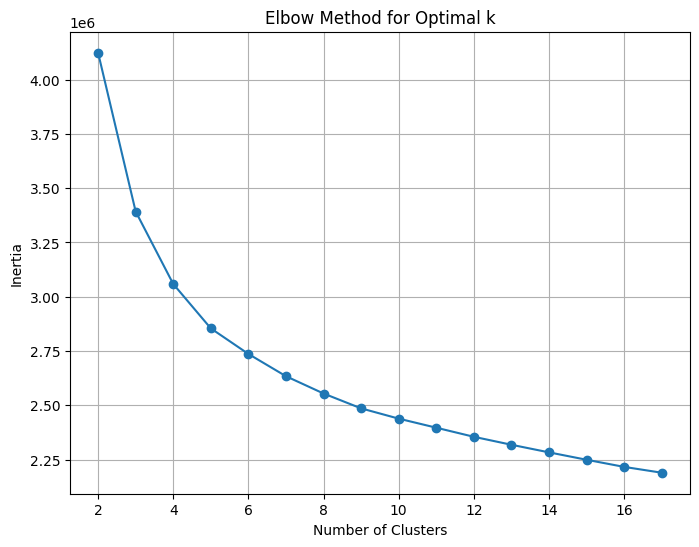

The optimal number of clusters is 6 based on the elbow method


In [78]:
## Model Analysis: Elbow analysis to see where inertia slows down

inertia = []
for k in range(2, 18):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot inertia vs. number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(2, 18), inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

print("The optimal number of clusters is 6 based on the elbow method")


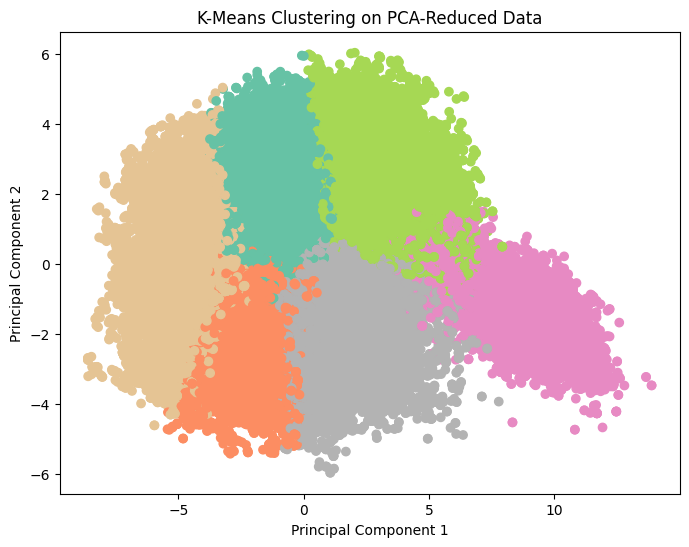

Execution Time: 5.4944 seconds


In [79]:
# Model Analysis: Final K-Means cluster 
import time
start_time = time.time()

kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
df_pca['KMeans_Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the clusters (using first two principal components for plotting)
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['KMeans_Cluster'], cmap='Set2')
plt.title("K-Means Clustering on PCA-Reduced Data")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

execution_time = time.time() - start_time
print(f"Execution Time: {execution_time:.4f} seconds")

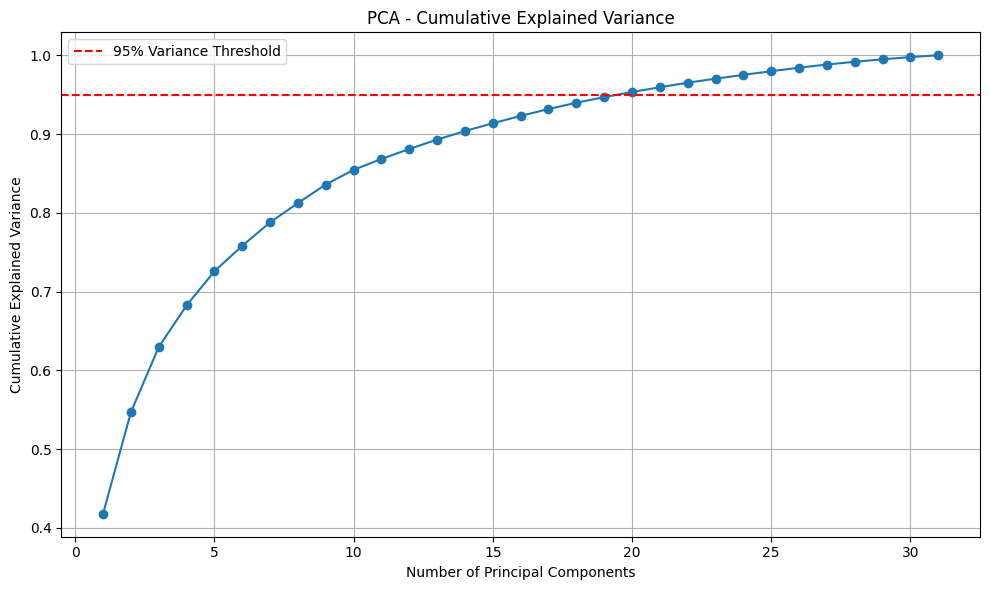

The number of components that meets the 95% threshold is 20


In [89]:
# ## Model Analysis: Hierachical Clustering 

## Use few components for Hierachical Clustering due to time complexity
idx = df_cleaned_2.groupby('player_fifa_api_id')['overall_rating'].idxmax()
df_best_rating = df_cleaned_2.loc[idx].reset_index(drop=True)
features = df_best_rating.drop(columns=['player_fifa_api_id'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA()
pca.fit(scaled_features)

# Calculate the number of components needed to explain 95% of the variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components_95 = (cumulative_variance >= 0.95).argmax() + 1

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         cumulative_variance, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.legend()
plt.tight_layout()
plt.show()

print(f"The number of components that meets the 95% threshold is {n_components_95}")

# Apply PCA with the number of components that meet the 95% variance threshold
pca = PCA(n_components=n_components_95)
principal_components = pca.fit_transform(scaled_features)

columns = [f"PC{i+1}" for i in range(n_components_95)]
df_pca = pd.DataFrame(principal_components, columns=columns)


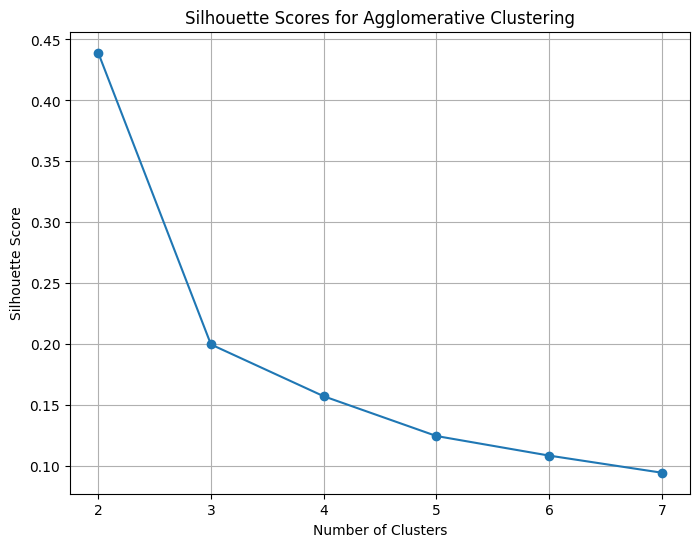

In [90]:
# ## Model Analysis: Hierachical Clustering with silhouetthe scoring

silhouette_scores = []
for k in range(2, 8):
    agg_clustering = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    labels = agg_clustering.fit_predict(df_pca)
    
    # Compute silhouette score for the current clustering
    score = silhouette_score(df_pca, labels, metric='euclidean')
    silhouette_scores.append(score)

# Plot silhouette scores to determine the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(2, 8), silhouette_scores, marker='o')
plt.title("Silhouette Scores for Agglomerative Clustering")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

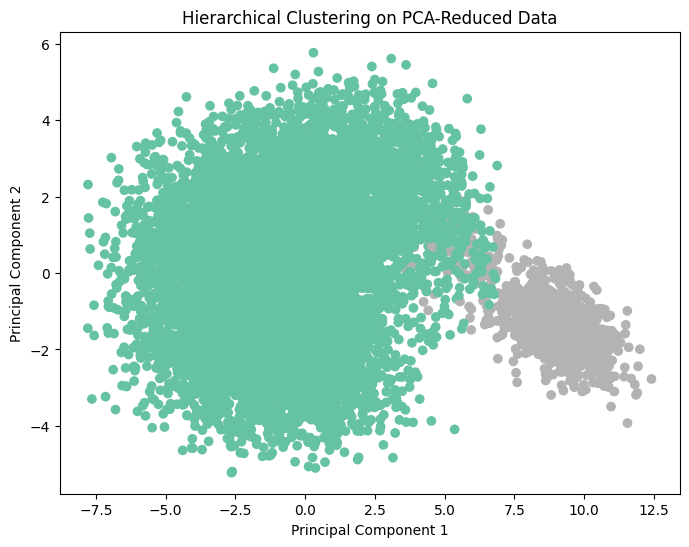

Execution Time: 2.0094 seconds


In [91]:
# Model Analysis: Final Hierarchical cluster 

start_time = time.time()
agg_clust = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
df_pca['Hierarchical_Cluster'] = agg_clust.fit_predict(df_pca)

# Visualize the clusters (using first two principal components for plotting)
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Hierarchical_Cluster'], cmap='Set2')
plt.title("Hierarchical Clustering on PCA-Reduced Data")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

execution_time = time.time() - start_time
print(f"Execution Time: {execution_time:.4f} seconds")


## Results and Conclusion

### Comparison of Clustering Techniques

| Technique                  | KMeans Clustering           | Agglomerative Clustering      |
|----------------------------|-----------------------------|-------------------------------|
| **Optimal Clusters**        | 6                           | 2                             |
| **Performance**             | Fast and scalable           | Slow and resource-intensive   |
| **Scalability**             | Handles full dataset        | Requires reduced dataset      |
| **Result Complexity**       | More granular               | More coarse                   |

---

### Key Observations
1. **Cluster Quality:**  
   - **KMeans:** 6 detailed clusters.  
   - **Agglomerative:** 2 oversimplified clusters.

2. **Performance:**  
   - **KMeans** handled the full dataset efficiently.  
   - **Agglomerative** needed dataset reduction due to high complexity.

3. **Interpretability:**  
   - **KMeans** provided clearer, more meaningful groupings.  
   - **Agglomerative** results were too general.


### Conclusion  
**KMeans** is more effective for player grouping due to its scalability, detailed clusters, and computational efficiency.
